In [310]:
# used libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import json
import requests
import os
from dotenv import load_dotenv
#from mpl_toolkits.basemap import Basemap ###ERROR###
import cartopy.crs as ccrs

In [292]:
# defined functions for pipeline
def acquire():
    raw_data = pd.read_csv('data\database.csv')
    return raw_data

def clean_nulls(raw_data):
    null_cols = raw_data.isnull().sum()
    drop_cols = list(null_cols[null_cols > 1000].index)
    data = raw_data.drop(drop_cols, axis=1)
    data = data.drop(['Type','ID','Source','Magnitude Type','Location Source', 'Magnitude Source','Status'], axis=1)
    return data

def binning_data(data):
    magnitude_labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
    bins = pd.cut(data['Magnitude'],5, labels=magnitude_labels)
    data['MagBin'] = bins
    binned_data = data
    return binned_data

def filtering_data(binned_data):
    bins_delete = ['Very Low', 'Low']
    filtered_data = binned_data[~binned_data.MagBin.isin(bins_delete)]
    filtered_data = filtered_data.reset_index().drop(['index'], axis=1)
    return filtered_data


def api_opencage(filtered_data):
#https://opencagedata.com/demo
    location = []
    load_dotenv('.env')
    key = os.environ.get("oc_key")
    for i in range(len(filtered_data.head())): # head para limitar el numero de llamadas hasta que el codigo este probado
        try:
            lat = filtered_data['Latitude'][i]
            long = filtered_data['Longitude'][i]
            url = ('https://api.opencagedata.com/geocode/v1/json?q={}%2C{}&key={}&language=en&pretty=1&no_annotations=1'.format(lat,long,key))
            response = requests.get(url)
            results = response.json()
            continent = results['results'][0]['components']['continent']
            country = results['results'][0]['components']['country']
            state = results['results'][0]['components']['state']
        except:
            continent = 'No continent'
            country = 'No country'
            state = 'No state'
        location.append([continent, country, state])
    locdf = pd.DataFrame(location, columns = ['Continent', 'Country', 'State'])
    data_loc = pd.concat([filtered_data, locdf], axis=1, sort=False)
    return data_loc

def plot_depth_mag(data_loc):
    plt.figure(figsize=(10, 8))
    style.use('ggplot')
    sc_plot = sns.scatterplot('Depth', 'Magnitude', size='Magnitude', data=data_loc, hue='Continent')
    return sc_plot

def point_map(data_loc):
    wmap_eq = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1,projection=ccrs.PlateCarree(central_longitude=-125))
    ax.set_global()
    ax.stock_img()
    ax.coastlines()
    ax.scatter(data_loc['Longitude']+125,data_loc['Latitude'])
    return wmap_eq

,Date,Time,Latitude,Longitude,Depth,Magnitude,MagBin,Continent,Country,State
0,01/24/1965,00:11:17,-2.608,125.952,20.0,8.2,High,Asia,Indonesia,North Maluku
1,02/04/1965,05:01:22,51.251,178.715,30.3,8.7,Very High,No continent,No country,No state
2,02/04/1965,08:40:44,51.443,179.605,30.0,7.3,Moderate,North America,USA,Alaska
3,02/23/1965,22:11:47,-25.633,-70.679,35.0,7.0,Moderate,South America,Chile,Antofagasta Region
4,03/14/1965,15:53:07,36.405,70.724,207.8,7.4,Moderate,Asia,Afghanistan,Badakhshan


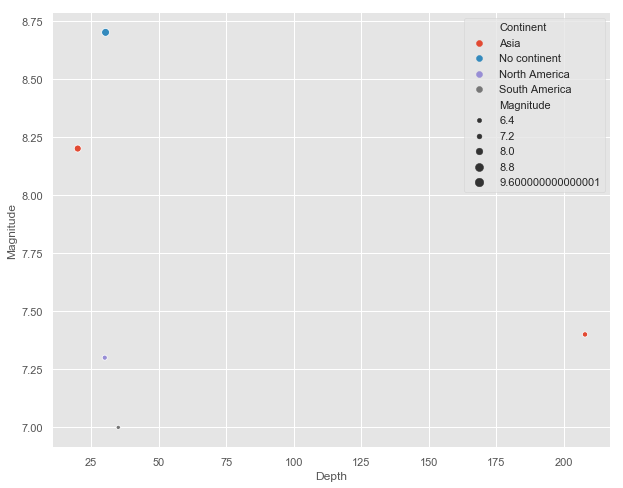

In [294]:
if __name__ == '__main__':
    raw_data = acquire()
    data = clean_nulls(raw_data)
    binned_data = binning_data(data)
    filtered_data = filtering_data(binned_data)
    data_loc = api_opencage(filtered_data)
    sc_plot = plot_depth_mag(data_loc)
    wmap_eq = point_map(data_loc) 
    

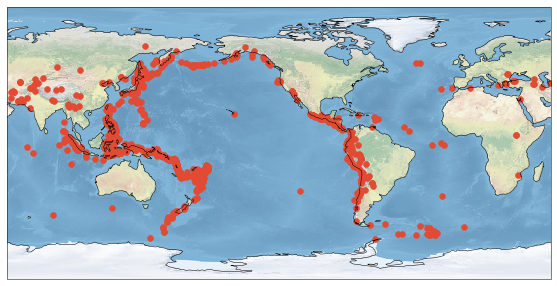

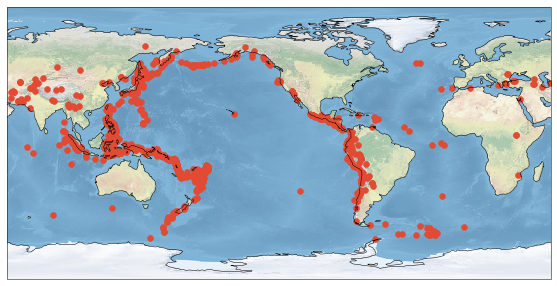